In [1]:
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from mapie.regression import MapieTimeSeriesRegressor

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

In [2]:
# Leitura dos Dados

df_bf = pd.read_excel('Botafogo-2015-2023_Semanal_Dengue.xlsx')
df_cd = pd.read_excel('CidadeDeDeus-2015-2023_Semanal_Dengue.xlsx')
df_cp = pd.read_excel('Copacabana-2015-2023_Semanal_Dengue.xlsx')
df_ed = pd.read_excel('EngenhoDeDentro-2015-2023_Semanal_Dengue.xlsx')
df_ip = pd.read_excel('Ipanema-2015-2023_Semanal_Dengue.xlsx')
df_lj = pd.read_excel('Laranjeiras-2015-2023_Semanal_Dengue.xlsx')
df_mc = pd.read_excel('Maracana-2015-2023_Semanal_Dengue.xlsx')
df_rc = pd.read_excel('Rocinha-2015-2023_Semanal_Dengue.xlsx')
df_vm = pd.read_excel('VilaMilitar-2015-2023_Semanal_Dengue.xlsx')
df_rl = pd.read_excel('Realengo-2015-2023_Semanal_Dengue.xlsx')

In [3]:
# Definir a coluna de datas como índice e garantir o tipo datetime
def prepare_dataframe(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df.set_index('data', inplace=True)
    return df

In [4]:
# Concatenação dos dados

dataframes = [prepare_dataframe(df) for df in [df_bf, df_cd, df_cp, df_ed, df_ip, df_lj, df_mc, df_rc, df_vm, df_rl]]
data = pd.concat(dataframes)

In [5]:
# OneHotEncoder na coluna Bairro
data = pd.get_dummies(data, columns=['bairro'])

In [6]:
# Variáveis Exógenas
exg = ['chuva', 'temperaturaMedia', 'temperaturaMaxima','temperaturaMinima', 'direcaoVento',
       'velocidadeVento', 'pressaoAtmosferica', 'semana','bairro_Botafogo',
       'bairro_Cidade de Deus', 'bairro_Copacabana',
       'bairro_Engenho de Dentro', 'bairro_Ipanema', 'bairro_Laranjeiras',
       'bairro_Maracana', 'bairro_Realengo', 'bairro_Rocinha',
       'bairro_Vila Militar']

In [7]:
data.sort_index(inplace=True)

# Manter uma cópia dos dados com índice de datas
data_with_dates = data.copy()

# Resetar o índice para a previsão autorregressiva
data.reset_index(drop=True, inplace=True)

In [8]:
# Split dos dados - train-test
steps = 1050
data_train = data[:-steps]
data_test  = data[-steps:]

data_train_dates = data_with_dates.iloc[:-steps]
data_test_dates  = data_with_dates.iloc[-steps:]

print(f"Train dates : {data_train_dates.index.min()} --- {data_train_dates.index.max()}  (n={len(data_train_dates)})")
print(f"Test dates  : {data_test_dates.index.min()} --- {data_test_dates.index.max()}  (n={len(data_test_dates)})")

Train dates : 2015-01-04 00:00:00 --- 2021-12-26 00:00:00  (n=3650)
Test dates  : 2022-01-02 00:00:00 --- 2023-12-31 00:00:00  (n=1050)


# PREVISÃO AUTORREGRESSIVA

In [9]:
# Previsão Autorregressiva
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 80
             )

forecaster.fit(y=data_train['dengueChikungunya'], exog=data_train[exg])

predictions = forecaster.predict(steps=steps, exog=data_test[exg])

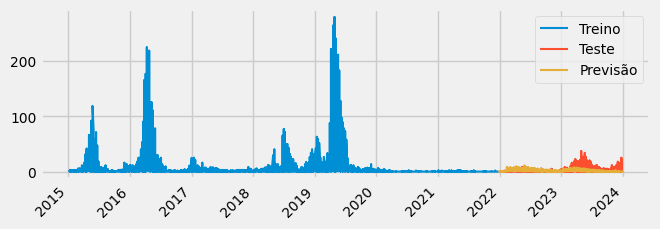

In [10]:
fig, ax = plt.subplots(figsize=(7, 2.5))

data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino')
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste')
predictions.index = data_test_dates.index 
predictions.plot(ax=ax, label='Previsão')

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.set_xlabel('') 
ax.legend()
plt.xticks(rotation=45)
plt.show()


In [11]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test['dengueChikungunya'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 14.139712952380952


In [12]:
predictions_interval = forecaster.predict_interval(
                    steps = steps,
                    interval = [5, 95],
                    n_boot   = 500,
                    exog=data_test[exg]
              )

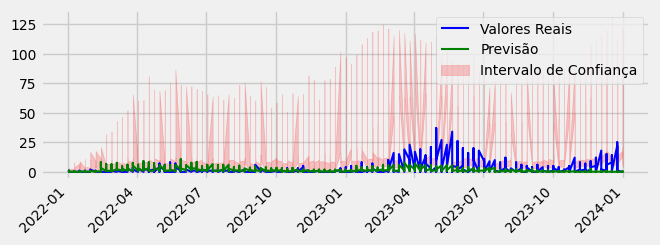

In [13]:
predictions.index = data_test_dates.index
predictions_interval.index = data_test_dates.index

fig, ax = plt.subplots(figsize=(7, 2.5))
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Valores Reais', color='blue')
predictions.plot(ax=ax, label='Previsão', color='green')
ax.fill_between(
    predictions_interval.index,
    np.maximum(predictions_interval['lower_bound'], 0),
    predictions_interval['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label='Intervalo de Confiança'
)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

ax.set_xlabel('')

ax.legend()
plt.show()


In [14]:
# Obter limites inferiores e superiores dos intervalos de confiança
lower_bound = predictions_interval['lower_bound']
upper_bound = predictions_interval['upper_bound']

# Valores reais
true_values = data_test_dates['dengueChikungunya']  # Usar o dataframe com as datas para manter o índice de data

# Alinhar os índices para garantir compatibilidade
true_values, lower_bound = true_values.align(lower_bound, join='inner')
true_values, upper_bound = true_values.align(upper_bound, join='inner')

# Verificar se os valores reais estão dentro dos intervalos
within_interval = (true_values >= lower_bound) & (true_values <= upper_bound)

# Calcular a cobertura como a proporção de valores dentro do intervalo
coverage = within_interval.sum() / len(true_values)

print(f'Cobertura do Intervalo de Confiança: {coverage:.2%}')

Cobertura do Intervalo de Confiança: 25.43%


In [15]:
# Calcular a média dos valores de dengueChikungunya no conjunto de treino
train_mean = data_train['dengueChikungunya'].mean()

# Criar previsões constantes usando a média do treino para o conjunto de teste
constant_predictions = np.full(len(data_test), train_mean)

# Calcular o MSE usando a média como previsão constante
mse_constant = mean_squared_error(data_test['dengueChikungunya'], constant_predictions)

print(f"MSE do modelo autorregressivo: {error_mse:.2f}")
print(f"MSE usando a média do conjunto de treino como previsão: {mse_constant:.2f}")

# Comparação dos resultados
if error_mse < mse_constant:
    print("O modelo autorregressivo performa melhor do que usar a média do conjunto de treino como previsão.")
else:
    print("Usar a média do conjunto de treino como previsão performa similarmente ou melhor do que o modelo autorregressivo.")

MSE do modelo autorregressivo: 14.14
MSE usando a média do conjunto de treino como previsão: 17.35
O modelo autorregressivo performa melhor do que usar a média do conjunto de treino como previsão.


## Analise por Bairro - Autorreg

In [16]:
predictions.index = data_test_dates.index

bairros = ['Botafogo', 'Cidade de Deus', 'Copacabana', 'Engenho de Dentro', 
           'Ipanema', 'Laranjeiras', 'Maracana', 'Realengo', 'Rocinha', 'Vila Militar']

mse_por_bairro = {}

In [17]:
for bairro in bairros:
    # Filtrar valores reais e previsões para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    predicted_values = predictions[mask]
    
    # Calcular o MSE para o bairro
    mse = mean_squared_error(y_true=real_values, y_pred=predicted_values)
    
    mse_por_bairro[bairro] = mse

In [18]:
# Exibir os MSEs por bairro
for bairro, mse in mse_por_bairro.items():
    print(f"{bairro}: MSE = {mse}")

Botafogo: MSE = 2.6934799999999997
Cidade de Deus: MSE = 7.232664761904761
Copacabana: MSE = 21.761748571428573
Engenho de Dentro: MSE = 12.374698095238095
Ipanema: MSE = 1.4139761904761905
Laranjeiras: MSE = 3.929053333333333
Maracana: MSE = 2.4135942857142862
Realengo: MSE = 66.76040857142857
Rocinha: MSE = 21.912141904761903
Vila Militar: MSE = 0.9053638095238096


In [19]:
# Garantir que os índices de predictions_interval estejam alinhados com os dados reais
predictions_interval.index = data_test_dates.index

cobertura_por_bairro = {}

for bairro in bairros:
    # Filtrar valores reais e intervalos para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    
    # Garantir que a máscara não esteja vazia
    if mask.sum() == 0:
        print(f"Atenção: Nenhum dado encontrado para o bairro {bairro}.")
        cobertura_por_bairro[bairro] = None
        continue

    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    lower_bound = predictions_interval.loc[mask, 'lower_bound']
    upper_bound = predictions_interval.loc[mask, 'upper_bound']
    
    # Checando o alinhamento dos índices
    if not real_values.index.equals(lower_bound.index):
        print(f"Desalinhamento de índices encontrado no bairro {bairro}. Realinhando os dados...")
        real_values = real_values.reindex(lower_bound.index)
    
    # Verificar se os valores reais estão dentro do intervalo de confiança
    inside_interval = (real_values >= lower_bound) & (real_values <= upper_bound)
    
    # Calcular a cobertura como a proporção de valores reais dentro do intervalo
    coverage = inside_interval.mean() * 100
    
    # Armazenar a cobertura
    cobertura_por_bairro[bairro] = coverage

# Exibir as coberturas por bairro
for bairro, coverage in cobertura_por_bairro.items():
    if coverage is not None:
        print(f"{bairro}: Cobertura do intervalo de confiança = {coverage:.2f}%")
    else:
        print(f"{bairro}: Cobertura do intervalo de confiança não calculada (dados ausentes).")

Botafogo: Cobertura do intervalo de confiança = 29.52%
Cidade de Deus: Cobertura do intervalo de confiança = 9.52%
Copacabana: Cobertura do intervalo de confiança = 40.00%
Engenho de Dentro: Cobertura do intervalo de confiança = 34.29%
Ipanema: Cobertura do intervalo de confiança = 20.95%
Laranjeiras: Cobertura do intervalo de confiança = 30.48%
Maracana: Cobertura do intervalo de confiança = 18.10%
Realengo: Cobertura do intervalo de confiança = 6.67%
Rocinha: Cobertura do intervalo de confiança = 33.33%
Vila Militar: Cobertura do intervalo de confiança = 31.43%


# MAPIE

In [20]:
# Inicialização MAPIE TimeSeriesRegressor
mapie_ts = MapieTimeSeriesRegressor(estimator=forecaster.regressor, method="enbpi")

In [21]:
# Fit MAPIE para train
mapie_ts.fit(data_train_dates[exg], data_train_dates['dengueChikungunya'])

# Predições com o intervalo
predictions_mapie, intervals = mapie_ts.predict(data_test_dates[exg], alpha=0.1)

In [22]:
# Certificando os intervalos com os formatos corretos
intervals = np.squeeze(np.asarray(intervals))

# Check the shape of intervals
print("Shape of intervals:", intervals.shape)

Shape of intervals: (1050, 2)


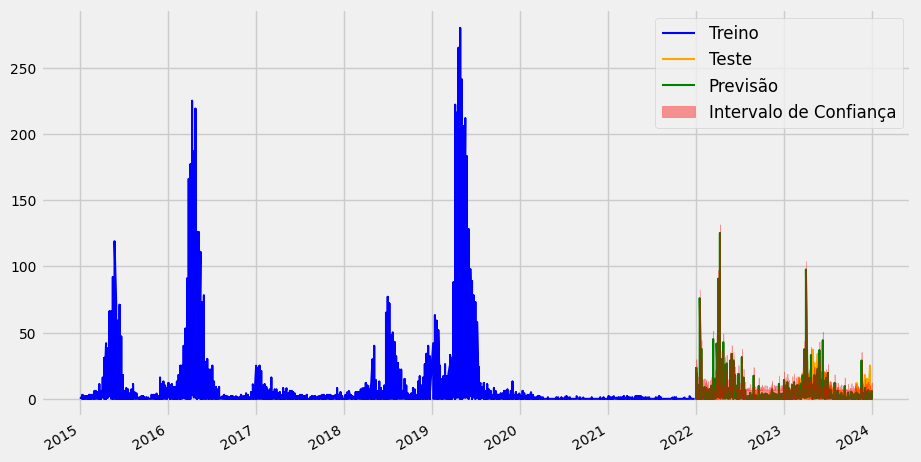

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino', color='blue', zorder=1)
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='orange', zorder=2)

ax.plot(data_test_dates.index, predictions_mapie, label='Previsão', color='green', zorder=3)

if intervals.ndim == 2 and intervals.shape[1] == 2:
    ax.fill_between(data_test_dates.index, np.maximum(intervals[:, 0], 0), intervals[:, 1], color='red', alpha=0.4, label='Intervalo de Confiança', zorder=4)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('')
ax.legend(handles, labels, loc='upper right', fontsize='large')
fig.autofmt_xdate()

plt.show()

In [24]:
# Test error
error_mse_mapie = mean_squared_error(data_test_dates['dengueChikungunya'], predictions_mapie)
print(f"Test error (mse): {error_mse_mapie}")

Test error (mse): 62.73645304761906


In [25]:
# Certificando-se de que intervals tenha duas colunas para os limites inferior e superior
if intervals.ndim == 2 and intervals.shape[1] == 2:
    lower_bound = intervals[:, 0]
    upper_bound = intervals[:, 1]

    # Verificar alinhamento dos índices e fazer comparações
    real_values = data_test_dates['dengueChikungunya'].reindex(data_test_dates.index)

    # Verificar se os valores reais estão dentro do intervalo de confiança
    inside_interval = (real_values >= lower_bound) & (real_values <= upper_bound)

    # Calcular a cobertura como a proporção de valores reais dentro do intervalo
    coverage = inside_interval.mean() * 100

    print(f"Cobertura do intervalo de confiança: {coverage:.2f}%")
else:
    print("Os intervalos não estão no formato correto para o cálculo da cobertura.")

Cobertura do intervalo de confiança: 90.29%


## Analise por Bairro - MAPIE

In [26]:
# Garantir que as previsões do MAPIE estejam alinhadas com o índice de datas
predictions_mapie = pd.Series(predictions_mapie, index=data_test_dates.index)

In [27]:
# Definindo a lista de bairros conforme os nomes gerados pelo OneHotEncoder
bairros = ['Botafogo', 'Cidade de Deus', 'Copacabana', 'Engenho de Dentro', 
           'Ipanema', 'Laranjeiras', 'Maracana', 'Realengo', 'Rocinha', 'Vila Militar']

mse_por_bairro_mapie = {}

In [28]:
for bairro in bairros:
    # Filtrando os valores reais e as previsões para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    predicted_values = predictions_mapie.loc[mask]
    
    # Calcular o MSE para o bairro específico
    mse = mean_squared_error(y_true=real_values, y_pred=predicted_values)
    
    mse_por_bairro_mapie[bairro] = mse

In [29]:
# Exibir os MSEs por bairro
for bairro, mse in mse_por_bairro_mapie.items():
    print(f"{bairro}: MSE = {mse}")

Botafogo: MSE = 9.87191904761905
Cidade de Deus: MSE = 61.53401904761905
Copacabana: MSE = 18.926734285714282
Engenho de Dentro: MSE = 17.93322380952381
Ipanema: MSE = 2.0919247619047616
Laranjeiras: MSE = 2.1852933333333335
Maracana: MSE = 3.2277761904761904
Realengo: MSE = 487.0580400000001
Rocinha: MSE = 23.52695238095238
Vila Militar: MSE = 1.008647619047619


In [30]:
# Garantir que os intervalos estejam alinhados com o índice de datas
intervals_df = pd.DataFrame(intervals, columns=['lower_bound', 'upper_bound'], index=data_test_dates.index)

cobertura_por_bairro_mapie = {}

for bairro in bairros:
    # Filtrando os valores reais e os intervalos para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    
    # Garantir que a máscara não esteja vazia
    if mask.sum() == 0:
        print(f"Atenção: Nenhum dado encontrado para o bairro {bairro}.")
        cobertura_por_bairro_mapie[bairro] = None
        continue

    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    lower_bound = intervals_df.loc[mask, 'lower_bound']
    upper_bound = intervals_df.loc[mask, 'upper_bound']
    
    # Alinhamento dos índices, se necessário
    real_values = real_values.reindex(lower_bound.index)

    # Verificar se os valores reais estão dentro do intervalo de confiança
    inside_interval = (real_values >= lower_bound) & (real_values <= upper_bound)
    
    # Calcular a cobertura como a proporção de valores reais dentro do intervalo
    coverage = inside_interval.mean() * 100
    
    cobertura_por_bairro_mapie[bairro] = coverage

# Exibir as coberturas por bairro
for bairro, coverage in cobertura_por_bairro_mapie.items():
    if coverage is not None:
        print(f"{bairro}: Cobertura do intervalo de confiança = {coverage:.2f}%")
    else:
        print(f"{bairro}: Cobertura do intervalo de confiança não calculada (dados ausentes).")


Botafogo: Cobertura do intervalo de confiança = 95.24%
Cidade de Deus: Cobertura do intervalo de confiança = 71.43%
Copacabana: Cobertura do intervalo de confiança = 89.52%
Engenho de Dentro: Cobertura do intervalo de confiança = 90.48%
Ipanema: Cobertura do intervalo de confiança = 100.00%
Laranjeiras: Cobertura do intervalo de confiança = 100.00%
Maracana: Cobertura do intervalo de confiança = 99.05%
Realengo: Cobertura do intervalo de confiança = 66.67%
Rocinha: Cobertura do intervalo de confiança = 90.48%
Vila Militar: Cobertura do intervalo de confiança = 100.00%
